# Simulating a Yo-Yo

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# download modsim.py if necessary

from os.path import exists

filename = 'modsim.py'
if not exists(filename):
    from urllib.request import urlretrieve
    url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    local, _ = urlretrieve(url+filename, filename)
    print('Downloaded ' + local)

In [2]:
import numpy
import pandas
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

## Yo-yo

Suppose you are holding a yo-yo with a length of string wound around its axle, and you drop it while holding the end of the string stationary. As gravity accelerates the yo-yo downward, tension in the string exerts a force upward. Since this force acts on a point offset from the center of mass, it exerts a torque that causes the yo-yo to spin.

The following diagram shows the forces on the yo-yo and the resulting torque. The outer shaded area shows the body of the yo-yo. The inner shaded area shows the rolled up string, the radius of which changes as the yo-yo unrolls.

![Diagram of a yo-yo showing forces due to gravity and tension in the
string, the lever arm of tension, and the resulting
torque.](https://github.com/AllenDowney/ModSim/raw/main/figs/yoyo.png)

In this system, we can't figure out the linear and angular acceleration independently; we have to solve a system of equations:

$\sum F = m a $

$\sum \tau = I \alpha$

where the summations indicate that we are adding up forces and torques.

As in the previous examples, linear and angular velocity are related because of the way the string unrolls:

$\frac{dy}{dt} = -r \frac{d \theta}{dt} $

In this example, the linear and angular accelerations have opposite sign.  As the yo-yo rotates counter-clockwise, $\theta$ increases and $y$, which is the length of the rolled part of the string, decreases.

Taking the derivative of both sides yields a similar relationship between linear and angular acceleration:

$\frac{d^2 y}{dt^2} = -r \frac{d^2 \theta}{dt^2} $

Which we can write more concisely:

$ a = -r \alpha $

This relationship is not a general law of nature; it is specific to scenarios like this where there is rolling without stretching or slipping.

Because of the way we've set up the problem, $y$ actually has two meanings: it represents the length of the rolled string and the height of the yo-yo, which decreases as the yo-yo falls.  Similarly, $a$ represents acceleration in the length of the rolled string and the height of the yo-yo.

We can compute the acceleration of the yo-yo by adding up the linear forces:

$\sum F = T - mg = ma $

Where $T$ is positive because the tension force points up, and $mg$ is negative because gravity points down.

Because gravity acts on the center of mass, it creates no torque, so the only torque is due to tension:

$\sum \tau = T r = I \alpha $

Positive (upward) tension yields positive (counter-clockwise) angular acceleration.

Now we have three equations in three unknowns, $T$, $a$, and $\alpha$, with $I$, $m$, $g$, and $r$ as known parameters.  We could solve these equations by hand, but we can also get SymPy to do it for us.

In [3]:
from sympy import symbols, Eq, solve

T, a, alpha, I, m, g, r = symbols('T a alpha I m g r')

In [4]:
eq1 = Eq(a, -r * alpha)
eq1

Eq(a, -alpha*r)

In [5]:
eq2 = Eq(T - m * g, m * a)
eq2

Eq(T - g*m, a*m)

In [6]:
eq3 = Eq(T * r, I * alpha)
eq3

Eq(T*r, I*alpha)

In [7]:
soln = solve([eq1, eq2, eq3], [T, a, alpha])

In [8]:
soln

{T: I*g*m/(I + m*r**2), a: -g*m*r**2/(I + m*r**2), alpha: g*m*r/(I + m*r**2)}

In [9]:
soln[T]

I*g*m/(I + m*r**2)

In [10]:
soln[a]

-g*m*r**2/(I + m*r**2)

In [11]:
soln[alpha]

g*m*r/(I + m*r**2)

The results are

$T      = m g I / I^*   $

$a      = -m g r^2 / I^* $

$\alpha = m g r / I^*    $

where $I^*$ is the augmented moment of inertia, $I + m r^2$.

You can also see [the derivation of these equations in this video](https://www.youtube.com/watch?v=chC7xVDKl4Q).

We can use these equations for $a$ and $\alpha$ to write a slope function and simulate this system.

**Exercise:**  Simulate the descent of a yo-yo.  How long does it take to reach the end of the string?

Here are the system parameters:

In [12]:
Rmin = 8e-3     # m
Rmax = 16e-3    # m
Rout = 35e-3    # m
mass = 50e-3    # kg
L = 1           # m
g = 9.8         # m / s**2

* `Rmin` is the radius of the axle.  `Rmax` is the radius of the axle plus rolled string.

* `Rout` is the radius of the yo-yo body.  `mass` is the total mass of the yo-yo, ignoring the string.  

* `L` is the length of the string.

* `g` is the acceleration of gravity.

In [13]:
1 / (Rmax)

62.5

Based on these parameters, we can compute the moment of inertia for the yo-yo, modeling it as a solid cylinder with uniform density ([see here](https://en.wikipedia.org/wiki/List_of_moments_of_inertia)).

In reality, the distribution of weight in a yo-yo is often designed to achieve desired effects.  But we'll keep it simple.

In [14]:
I = mass * Rout**2 / 2
I

3.0625000000000006e-05

And we can compute `k`, which is the constant that determines how the radius of the spooled string decreases as it unwinds.

In [15]:
k = (Rmax**2 - Rmin**2) / 2 / L   
k

9.6e-05

The state variables we'll use are angle, `theta`, angular velocity, `omega`, the length of the spooled string, `y`, and the linear velocity of the yo-yo, `v`.

Here is a `State` object with the the initial conditions.

In [16]:
init = modsim.State(theta=0, omega=0, y=L, v=0)

And here's a `System` object with `init` and `t_end` (chosen to be longer than I expect for the yo-yo to drop 1 m).

In [17]:
system = modsim.System(init=init, t_end=2)

Write a slope function for this system, using these results from the book:

$ r = \sqrt{2 k y + R_{min}^2} $ 

$ T      = m g I / I^*  $

$ a      = -m g r^2 / I^* $

$ \alpha  = m g r / I^*  $

where $I^*$ is the augmented moment of inertia, $I + m r^2$.

In [42]:
# Solution goes here
def slope_func(t, state, system):
    theta, omega, y, v = state

    r = numpy.sqrt(2*k*y + Rmin**2)
    I_aug = I + mass*r**2
    T = mass*g*I/I_aug
    a = -mass*g*r**2/I_aug
    alpha = mass*g*r/I_aug

    return omega, alpha, v, a


Test your slope function with the initial conditions.
The results should be approximately

```
0, 180.5, 0, -2.9
```

In [43]:
# Solution goes here
slope_func(0, system.init, system)

(0, 180.54116292458264, 0, -2.8886586067933218)

Notice that the initial acceleration is substantially smaller than `g` because the yo-yo has to start spinning before it can fall.

Write an event function that will stop the simulation when `y` is 0.

In [44]:
# Solution goes here
def event_func(t, state, system):
    theta, omega, y, v = state
    return y

Test your event function:

In [45]:
# Solution goes here
event_func(0, system.init, system)

1

Then run the simulation.

In [46]:
# Solution goes here
results, details = modsim.run_solve_ivp(system, slope_func, events=event_func)
details.message

/var/folders/l1/s403nrfs3_158_z9lrw5190c0000gn/T/ipykernel_2525/3877904791.py:5: RuntimeWarning: invalid value encountered in sqrt
  r = numpy.sqrt(2*k*y + Rmin**2)


'A termination event occurred.'

Check the final state.  If things have gone according to plan, the final value of `y` should be close to 0.

In [47]:
# Solution goes here
results.tail()

,theta,omega,y,v
0.844032,62.100083,140.385022,6.953811e-02,-1.958980
0.852824,63.339147,141.474237,5.227283e-02,-1.968457
0.861616,64.587699,142.544295,3.492584e-02,-1.977562
0.870408,65.845568,143.594405,1.750045e-02,-1.986289
0.879200,67.112586,144.623824,9.714451e-17,-1.994634


How long does it take for the yo-yo to fall 1 m?  Does the answer seem reasonable?

The following cells plot the results.

`theta` should increase and accelerate.

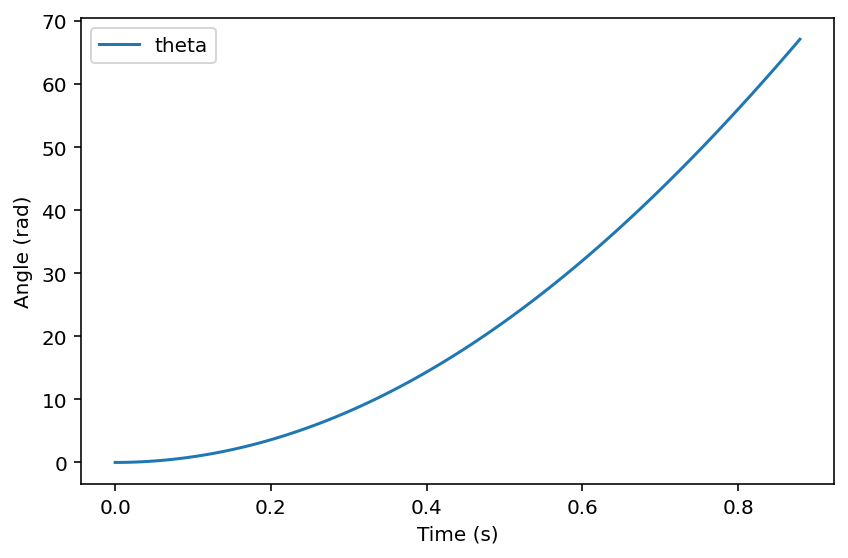

In [48]:
results.theta.plot(color='C0', label='theta')
modsim.decorate(xlabel='Time (s)',
         ylabel='Angle (rad)')

`y` should decrease and accelerate down.

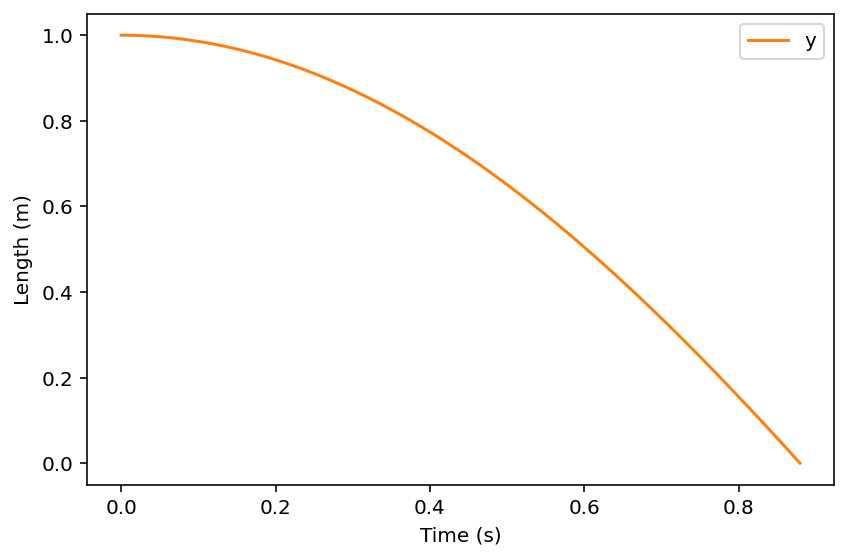

In [49]:
results.y.plot(color='C1', label='y')

modsim.decorate(xlabel='Time (s)',
         ylabel='Length (m)')
    

Plot velocity as a function of time; is the acceleration constant?

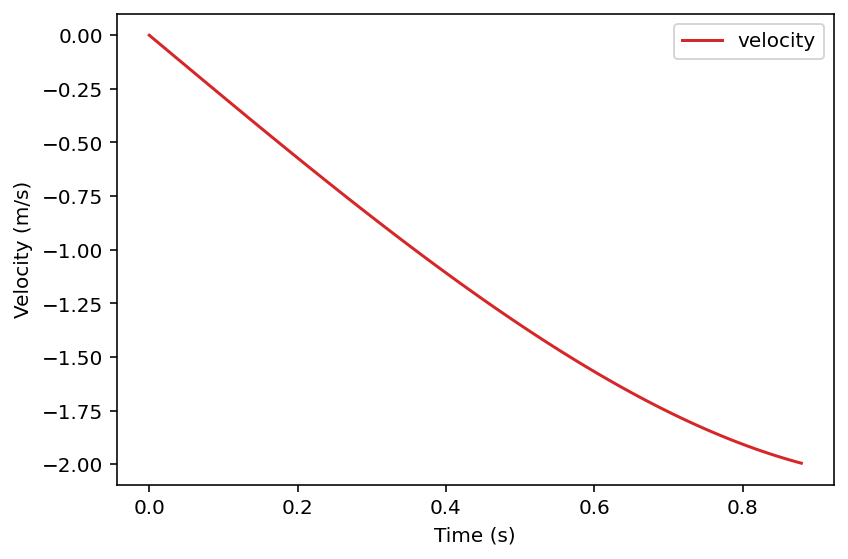

In [50]:
results.v.plot(label='velocity', color='C3')

modsim.decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

We can use `gradient` to estimate the derivative of `v`.  How does the acceleration of the yo-yo compare to `g`?

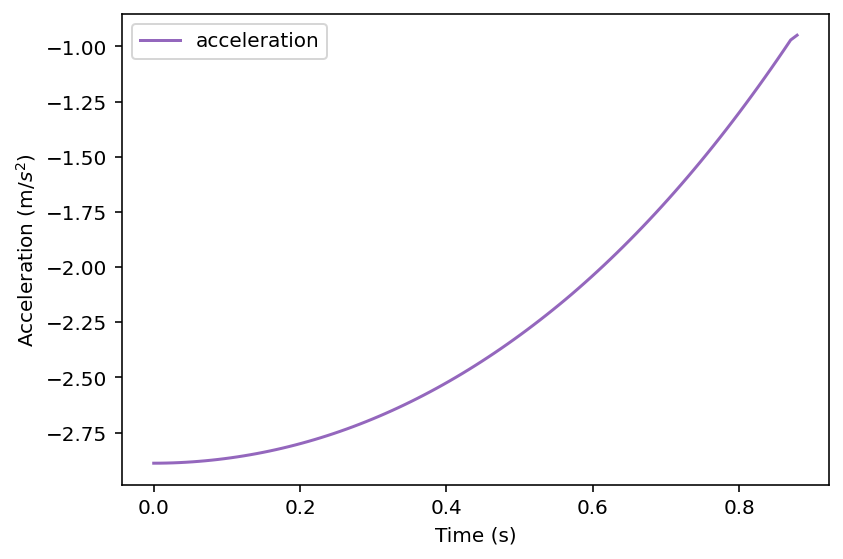

In [51]:
a = modsim.gradient(results.v)
a.plot(label='acceleration', color='C4')
modsim.decorate(xlabel='Time (s)',
         ylabel='Acceleration (m/$s^2$)')

And we can use the formula for `r` to plot the radius of the spooled thread over time.

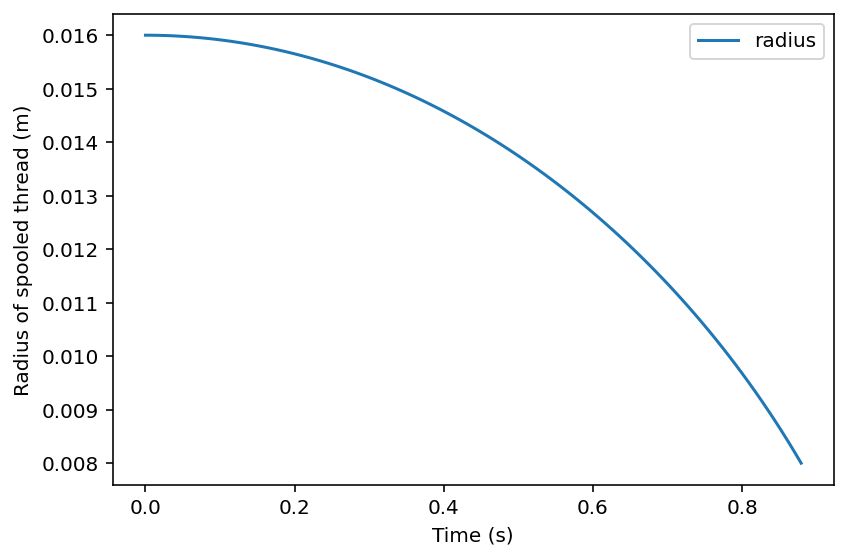

In [53]:
r = numpy.sqrt(2*k*results.y + Rmin**2)
r.plot(label='radius')

modsim.decorate(xlabel='Time (s)',
         ylabel='Radius of spooled thread (m)')